In [2]:
# Cell 1: Imports and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from textblob import TextBlob

import os  # לפעולות מערכת כמו os.path.join
from sklearn.preprocessing import StandardScaler  # לנרמול נתונים
from sklearn.decomposition import PCA, NMF  # לניתוח רכיבים עיקריים ומטריצות
from textblob import TextBlob  # לעיבוד שפה טבעית

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [3]:
# Cell 2: Load dataset
def load_ev_dataset(base_path=None):
    # Try to locate dataset file if provided path is None
    if base_path:
        dataset_file = base_path
    else:
        # search current directory for plausible file
        candidates = [f for f in os.listdir('.') if 'electric' in f.lower() and f.lower().endswith('.csv')]
        if not candidates:
            raise FileNotFoundError("No CSV dataset found in cwd. Please download and place the file here.")
        dataset_file = candidates[0]
    print("Using dataset file:", dataset_file)
    df = pd.read_csv(dataset_file)
    return df

# Example usage:
# df = load_ev_dataset("electric_vehicles_spec_2025.csv")

In [4]:
# Cell 3: Basic exploratory data analysis
def basic_eda(df):
    print("\n===== COLUMNS =====")
    print(df.columns.tolist())
    print("\n===== INFO =====")
    df.info()
    print("\n===== HEAD =====")
    display(df.head())
    print("\n===== DESCRIBE =====")
    display(df.describe(include='all'))
    print("\n===== MISSING VALUES =====")
    print(df.isnull().sum())
    print("\n===== UNIQUE VALUE SAMPLES =====")
    for col in df.columns:
        sample = df[col].dropna().unique()[:5]
        print(f"{col}: {sample}")

In [5]:
# Cell 4: Descriptive statistics & distributions for selected numeric columns
def stats_and_distributions(df):
    numeric_columns = [
        'top_speed_kmh',
        'battery_capacity_kWh',
        'number_of_cells',
        'torque_nm',
        'efficiency_wh_per_km',
        'range_km',
        'acceleration_0_100_s',
        'fast_charging_power_kw_dc',
        'towing_capacity_kg',
        'cargo_volume_l',
        'seats',
        'length_mm',
        'width_mm',
        'height_mm'
    ]
    existing = [c for c in numeric_columns if c in df.columns]
    if not existing:
        print('No expected numeric columns found in dataset.')
        return
    numeric_df = df[existing].apply(pd.to_numeric, errors='coerce')
    print('\n===== DESCRIPTIVE STATISTICS =====')
    display(numeric_df.describe())
    # Histograms
    for col in existing:
        series = numeric_df[col].dropna()
        if series.empty:
            continue
        plt.figure(figsize=(6,4))
        plt.hist(series, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    # Correlation
    corr = numeric_df.corr()
    print('\n===== CORRELATION MATRIX =====')
    display(corr)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.title('Correlation matrix heatmap (simple)')
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.index)
    plt.tight_layout()
    plt.show()
    # Duplicates
    print('\n===== DUPLICATES =====')
    print('Duplicated rows:', df.duplicated().sum())
    print('Unique rows:', df.drop_duplicates().shape[0])

In [21]:
# Cell 5: Clustering with KMeans
def perform_clustering(df, n_clusters=4):
    numeric_df = df.select_dtypes(include=['number'])
    clean_df = numeric_df.dropna()

    if clean_df.empty:
        print("⚠️ No numeric data available for clustering.")
        return None, df

    scaler = StandardScaler()
    scaled = scaler.fit_transform(clean_df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled)

    # יצירת עותק מהשורות הרלוונטיות בלבד
    df_clustered = df.loc[clean_df.index].copy()
    df_clustered['cluster'] = labels

    print("✅ Clustering completed. Cluster distribution:")
    print(df_clustered['cluster'].value_counts())

    display(df_clustered.head())

    return df_clustered, kmeans

       

In [7]:
# Cell 6: Segment analysis and PCA visualization
def segment_analysis(df_filtered):
    if 'cluster' not in df_filtered.columns:
        print("Need clustering first.")
        return
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns.tolist()
    segment_summary = df_filtered.groupby('cluster').mean(numeric_only=True)
    print("Mean values per segment:")
    display(segment_summary)
    # PCA
    pca_data = df_filtered[numeric_cols].dropna()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pca_data)
    pca = PCA(n_components=2)
    comps = pca.fit_transform(scaled)
    df_plot = df_filtered.loc[pca_data.index].copy()
    df_plot['PCA1'] = comps[:,0]
    df_plot['PCA2'] = comps[:,1]
    plt.figure(figsize=(8,6))
    for cid in sorted(df_plot['cluster'].unique()):
        subset = df_plot[df_plot['cluster']==cid]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cid}', alpha=0.6)
    plt.title('PCA of EV dataset colored by cluster')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# Cell 7: Text sentiment and topic modeling (requires 'description' column)
def text_and_topic_processing(df):
    if 'description' not in df.columns:
        print("No 'description' column present.")
        return df
    # Sentiment
    df = df.copy()
    df['sentiment_score'] = df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    # Topic modeling
    vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
    X = vectorizer.fit_transform(df['description'])
    nmf_model = NMF(n_components=3, random_state=42)
    nmf_features = nmf_model.fit_transform(X)
    topic_labels = ['Topic0','Topic1','Topic2']
    df['topic'] = nmf_features.argmax(axis=1)
    df['topic_label'] = df['topic'].apply(lambda i: topic_labels[i])
    # Style classification
    def classify_style(text):
        t = str(text).lower()
        if any(word in t for word in ['luxury', 'comfort', 'premium']):
            return 'Luxury'
        elif any(word in t for word in ['tech', 'ai', 'dashboard', 'futuristic']):
            return 'Technology'
        elif any(word in t for word in ['family', 'economical', 'utility']):
            return 'Utility'
        else:
            return 'General'
    df['writing_style'] = df['description'].apply(classify_style)
    # Visualizations
    plt.figure(figsize=(8,4))
    df_plot = df.copy()
    df_plot.groupby('topic_label')['sentiment_score'].mean().plot.bar()
    plt.title('Average Sentiment Score per Topic')
    plt.ylabel('Sentiment Polarity')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    df['writing_style'].value_counts().plot.bar()
    plt.title('Distribution of Writing Styles')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(7,5))
    pd.crosstab(df['topic_label'], df['writing_style']).plot(kind='bar', stacked=False)
    plt.title('Topic Label by Writing Style')
    plt.tight_layout()
    plt.show()
    display(df[['model','description','sentiment_score','topic_label','writing_style']])
    return df

In [18]:
# Cell 8: Modeling: KMeans on selected features and Naive Bayes text classification
def build_and_evaluate_models(df):
    # Clustering on numeric features (filter out non-numeric safely)
    features = ['range_km', 'fast_charging_power_kw_dc', 'cargo_volume_l', 'seats']
    available = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    if available:
        clustering_df = df[available].dropna()
        if not clustering_df.empty:
            try:
                kmeans = KMeans(n_clusters=2, random_state=0)
                df['cluster'] = kmeans.fit_predict(clustering_df)
                print("✅ KMeans clustering labels added.")
            except Exception as e:
                df['cluster'] = pd.NA
                print(f"❌ Clustering failed: {e}")
        else:
            df['cluster'] = pd.NA
            print("⚠️ Not enough data for clustering.")
    else:
        df['cluster'] = pd.NA
        print("⚠️ Required numeric features missing:", features)

    # Text classification only if columns exist
    if 'description' in df.columns and 'writing_style' in df.columns:
        try:
            vectorizer = TfidfVectorizer(stop_words='english')
            X = vectorizer.fit_transform(df['description'].astype(str))  # Convert to string just in case
            y = df['writing_style']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            clf = MultinomialNB()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            report = classification_report(y_test, y_pred)
            print("=== Classification Report ===")
            print(report)
        except Exception as e:
            print(f"❌ Text modeling failed: {e}")
    else:
        print("⚠️ Text classification skipped; 'description' or 'writing_style' column missing.")

        

✅ Data loaded successfully.

===== COLUMNS =====
['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh', 'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km', 'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc', 'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats', 'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm', 'car_body_type', 'source_url']

===== INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm      

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,fast_charge_port,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,67.0,CCS,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,67.0,CCS,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,79.0,CCS,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,79.0,CCS,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,78.0,CCS,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5



===== DESCRIBE =====


,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,fast_charge_port,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
count,478,477,478.000000,478.000000,478,276.000000,471.000000,478.000000,478.000000,478.000000,477.000000,477,452.000000,477,478.000000,478,478,478.000000,478.000000,478.000000,478,478
unique,59,477,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,140,NaN,3,15,NaN,NaN,NaN,8,478
top,Mercedes-Benz,X Privilege AWD (MY25),NaN,NaN,Lithium-ion,NaN,NaN,NaN,NaN,NaN,NaN,CCS,NaN,520,NaN,AWD,JC - Medium,NaN,NaN,NaN,SUV,https://ev-database.org/car/3178/firefly-firefly
freq,42,1,NaN,NaN,478,NaN,NaN,NaN,NaN,NaN,NaN,476,NaN,17,NaN,191,91,NaN,NaN,NaN,244,1
mean,NaN,NaN,185.487448,74.043724,NaN,485.293478,498.012739,162.903766,393.179916,6.882636,125.008386,NaN,1052.261062,NaN,5.263598,NaN,NaN,4678.506276,1887.359833,1601.125523,NaN,NaN
std,NaN,NaN,34.252773,20.331058,NaN,1210.819733,241.461128,34.317532,103.287335,2.730696,58.205012,NaN,737.851774,NaN,1.003961,NaN,NaN,369.210573,73.656807,130.754851,NaN,NaN
min,NaN,NaN,125.000000,21.300000,NaN,72.000000,113.000000,109.000000,135.000000,2.200000,29.000000,NaN,0.000000,NaN,2.000000,NaN,NaN,3620.000000,1610.000000,1329.000000,NaN,NaN
25%,NaN,NaN,160.000000,60.000000,NaN,150.000000,305.000000,143.000000,320.000000,4.800000,80.000000,NaN,500.000000,NaN,5.000000,NaN,NaN,4440.000000,1849.000000,1514.000000,NaN,NaN
50%,NaN,NaN,180.000000,76.150000,NaN,216.000000,430.000000,155.000000,397.500000,6.600000,113.000000,NaN,1000.000000,NaN,5.000000,NaN,NaN,4720.000000,1890.000000,1596.000000,NaN,NaN
75%,NaN,NaN,201.000000,90.600000,NaN,324.000000,679.000000,177.750000,470.000000,8.200000,150.000000,NaN,1600.000000,NaN,5.000000,NaN,NaN,4961.000000,1939.000000,1665.000000,NaN,NaN



===== MISSING VALUES =====
brand                          0
model                          1
top_speed_kmh                  0
battery_capacity_kWh           0
battery_type                   0
number_of_cells              202
torque_nm                      7
efficiency_wh_per_km           0
range_km                       0
acceleration_0_100_s           0
fast_charging_power_kw_dc      1
fast_charge_port               1
towing_capacity_kg            26
cargo_volume_l                 1
seats                          0
drivetrain                     0
segment                        0
length_mm                      0
width_mm                       0
height_mm                      0
car_body_type                  0
source_url                     0
dtype: int64

===== UNIQUE VALUE SAMPLES =====
brand: ['Abarth' 'Aiways' 'Alfa' 'Alpine' 'Audi']
model: ['500e Convertible' '500e Hatchback' '600e Scorpionissima' '600e Turismo'
 'U5']
top_speed_kmh: [155 200 150 160 170]
battery_capacity_kWh: [3

,top_speed_kmh,battery_capacity_kWh,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,cargo_volume_l,seats,length_mm,width_mm,height_mm
count,478.000000,478.000000,276.000000,471.000000,478.000000,478.000000,478.000000,477.000000,452.000000,474.000000,478.000000,478.000000,478.000000,478.000000
mean,185.487448,74.043724,485.293478,498.012739,162.903766,393.179916,6.882636,125.008386,1052.261062,493.860759,5.263598,4678.506276,1887.359833,1601.125523
std,34.252773,20.331058,1210.819733,241.461128,34.317532,103.287335,2.730696,58.205012,737.851774,187.005674,1.003961,369.210573,73.656807,130.754851
min,125.000000,21.300000,72.000000,113.000000,109.000000,135.000000,2.200000,29.000000,0.000000,151.000000,2.000000,3620.000000,1610.000000,1329.000000
25%,160.000000,60.000000,150.000000,305.000000,143.000000,320.000000,4.800000,80.000000,500.000000,385.000000,5.000000,4440.000000,1849.000000,1514.000000
50%,180.000000,76.150000,216.000000,430.000000,155.000000,397.500000,6.600000,113.000000,1000.000000,470.000000,5.000000,4720.000000,1890.000000,1596.000000
75%,201.000000,90.600000,324.000000,679.000000,177.750000,470.000000,8.200000,150.000000,1600.000000,544.500000,5.000000,4961.000000,1939.000000,1665.000000
max,325.000000,118.000000,7920.000000,1350.000000,370.000000,685.000000,19.100000,281.000000,2500.000000,1410.000000,9.000000,5908.000000,2080.000000,1986.000000


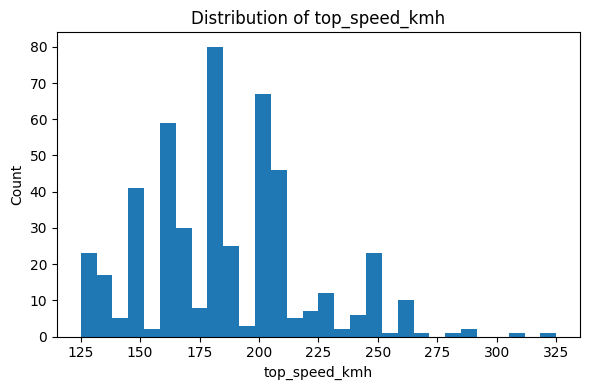

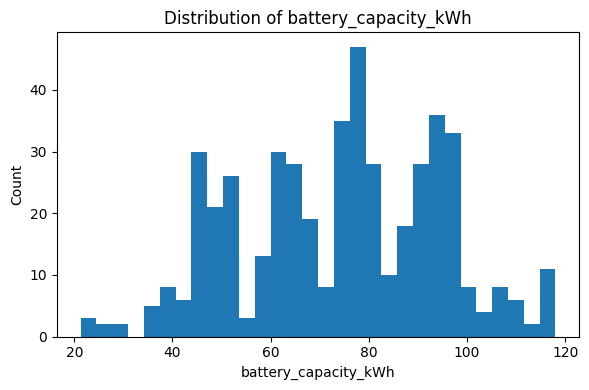

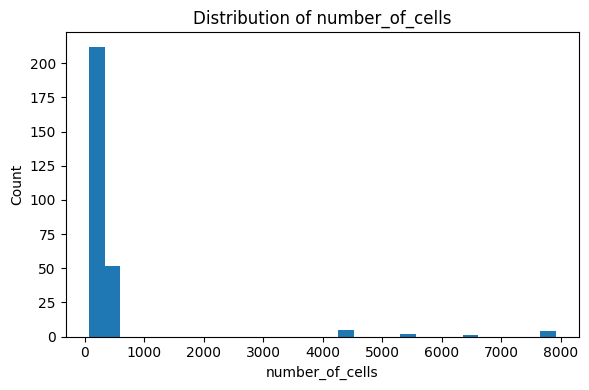

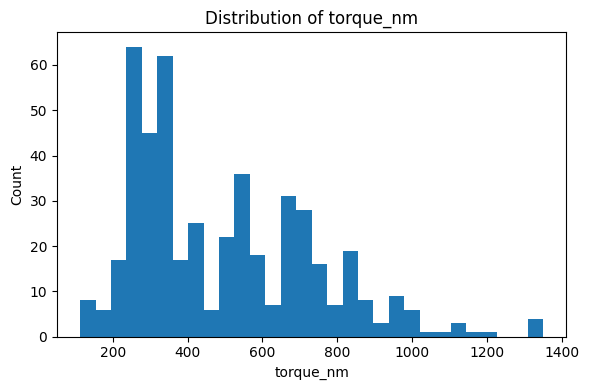

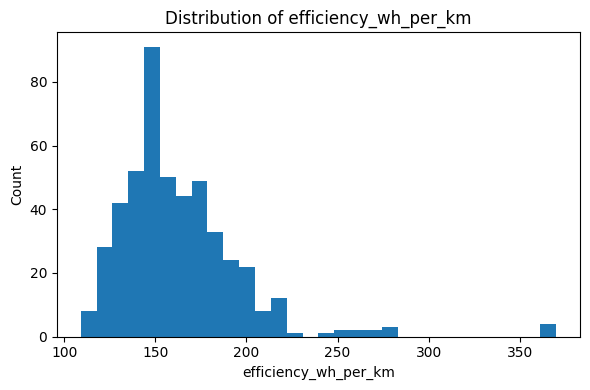

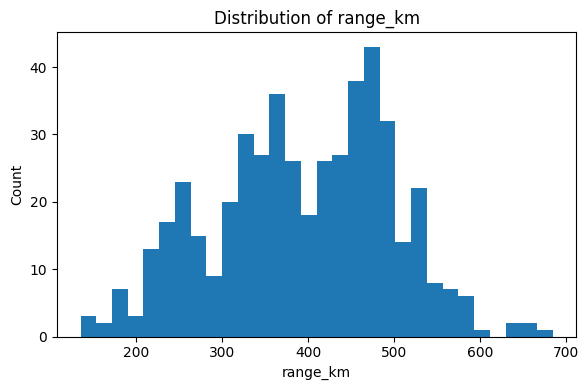

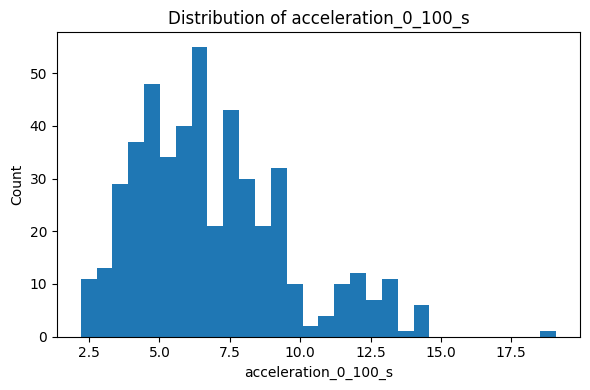

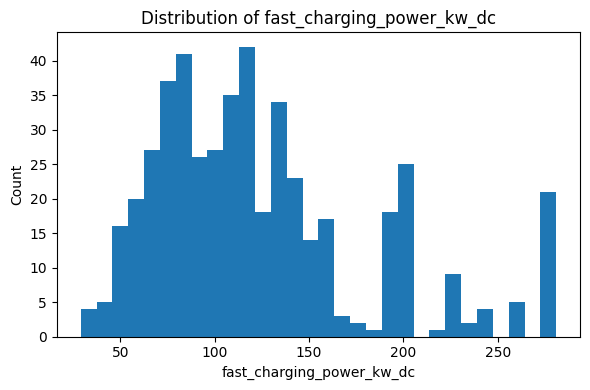

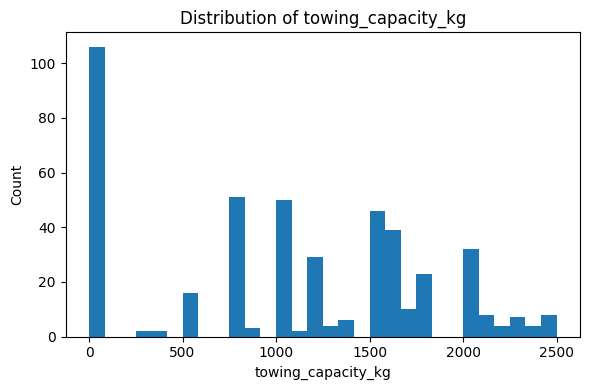

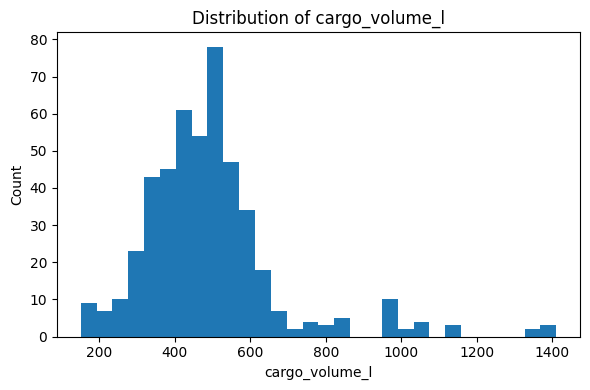

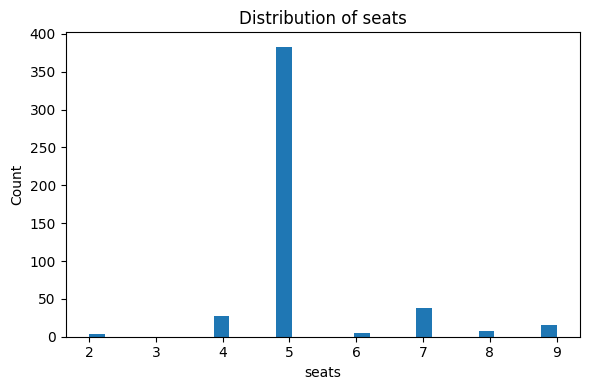

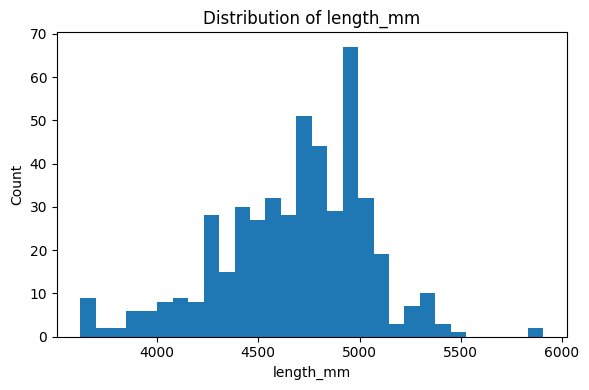

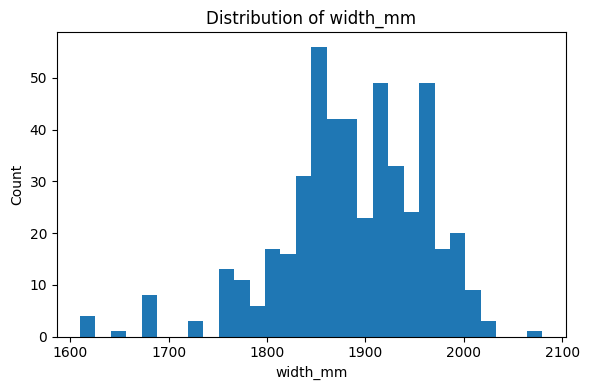

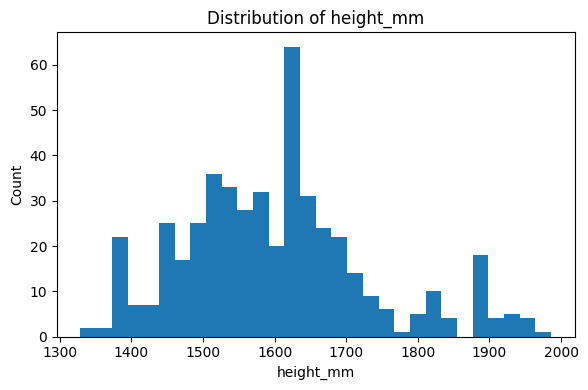


===== CORRELATION MATRIX =====


,top_speed_kmh,battery_capacity_kWh,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,cargo_volume_l,seats,length_mm,width_mm,height_mm
top_speed_kmh,1.000000,0.708486,0.361792,0.805513,0.171242,0.732130,-0.823443,0.771810,0.231041,-0.160174,-0.315572,0.443686,0.535850,-0.462712
battery_capacity_kWh,0.708486,1.000000,0.214515,0.756932,0.383607,0.880433,-0.643716,0.728066,0.451132,0.122163,0.013413,0.689293,0.731496,-0.055999
number_of_cells,0.361792,0.214515,1.000000,0.164120,-0.077907,0.311014,-0.254122,0.094389,0.070286,0.090176,0.030315,0.181904,0.205763,-0.132658
torque_nm,0.805513,0.756932,0.164120,1.000000,0.370422,0.651651,-0.787623,0.656593,0.352548,-0.037816,-0.162736,0.508932,0.572241,-0.195872
efficiency_wh_per_km,0.171242,0.383607,-0.077907,0.370422,1.000000,0.022943,-0.066512,0.182031,0.250221,0.405396,0.522634,0.644838,0.573535,0.512614
range_km,0.732130,0.880433,0.311014,0.651651,0.022943,1.000000,-0.712486,0.720932,0.333962,-0.065701,-0.248784,0.496867,0.521392,-0.413798
acceleration_0_100_s,-0.823443,-0.643716,-0.254122,-0.787623,-0.066512,-0.712486,1.000000,-0.628553,-0.286155,0.290790,0.441376,-0.254990,-0.395869,0.494811
fast_charging_power_kw_dc,0.771810,0.728066,0.094389,0.656593,0.182031,0.720932,-0.628553,1.000000,0.236353,-0.017317,-0.128115,0.474058,0.574412,-0.290376
towing_capacity_kg,0.231041,0.451132,0.070286,0.352548,0.250221,0.333962,-0.286155,0.236353,1.000000,0.154131,0.151832,0.401418,0.468550,0.300047
cargo_volume_l,-0.160174,0.122163,0.090176,-0.037816,0.405396,-0.065701,0.290790,-0.017317,0.154131,1.000000,0.510118,0.486432,0.403011,0.600376


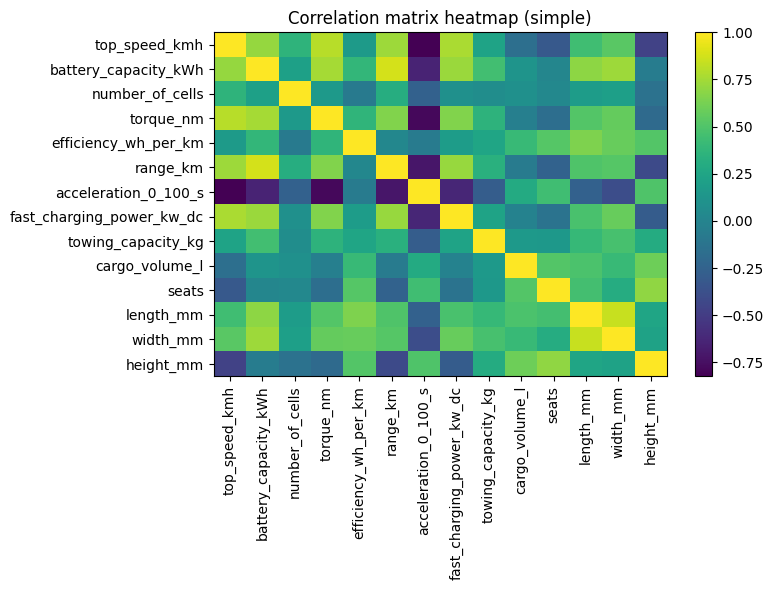


===== DUPLICATES =====
Duplicated rows: 0
Unique rows: 478
📊 Categorical Columns Analysis:

📌 Feature: brand
 Unique values: 59
brand
Mercedes-Benz    42
Audi             28
Porsche          26
Volkswagen       23
Ford             22
BMW              20
Peugeot          19
Volvo            18
BYD              17
Smart            17
Name: count, dtype: int64
----------------------------------------

📌 Feature: model
 Unique values: 477
model
NaN                                     1
500e Convertible                        1
500e Hatchback                          1
600e Scorpionissima                     1
600e Turismo                            1
U5                                      1
U6                                      1
Romeo Junior Elettrica 54 kWh           1
Romeo Junior Elettrica 54 kWh Veloce    1
A290 Electric 180 hp                    1
Name: count, dtype: int64
----------------------------------------

📌 Feature: battery_type
 Unique values: 1
battery_type
Lithium-ion

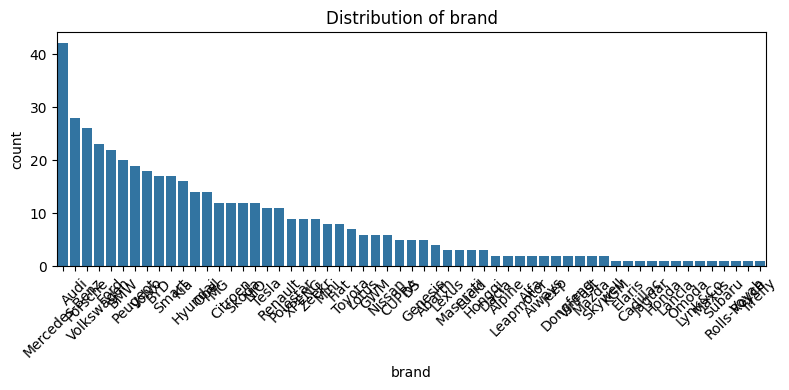

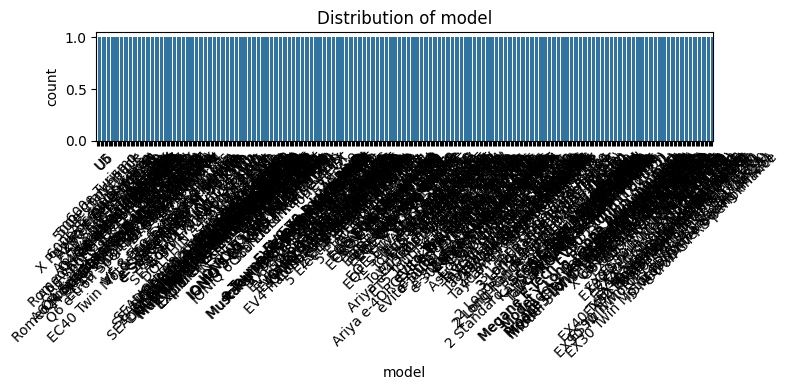

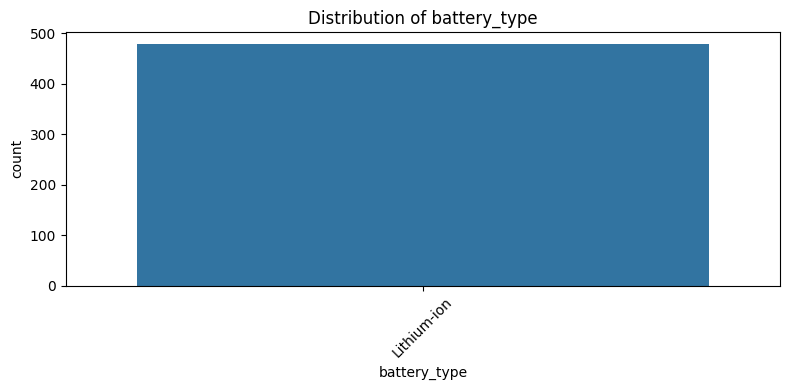

 Outliers detected per numeric column (|Z| > 3):
top_speed_kmh            4
efficiency_wh_per_km     9
acceleration_0_100_s     1
seats                   18
length_mm                2
width_mm                 5
dtype: int64
🔴 Total rows with at least one outlier: 35 out of 478


,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,fast_charge_port,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
89,Citroen,e-SpaceTourer M 50 kWh,130,46.3,Lithium-ion,216.0,220.0,217,180,13.3,78.0,CCS,1000.0,603,9,FWD,N - Passenger Van,4983,1920,1890,Small Passenger Van,https://ev-database.org/car/2252/Citroen-e-Spa...
90,Citroen,e-SpaceTourer M 75 kWh,130,68.0,Lithium-ion,324.0,220.0,202,260,14.2,79.0,CCS,1000.0,603,9,FWD,N - Passenger Van,4983,1920,1890,Small Passenger Van,https://ev-database.org/car/2254/Citroen-e-Spa...
91,Citroen,e-SpaceTourer XL 50 kWh,130,46.3,Lithium-ion,216.0,220.0,219,180,13.3,78.0,CCS,1000.0,989,9,FWD,N - Passenger Van,5333,1920,1890,Small Passenger Van,https://ev-database.org/car/2253/Citroen-e-Spa...
92,Citroen,e-SpaceTourer XL 75 kWh,130,68.0,Lithium-ion,324.0,220.0,204,260,14.2,79.0,CCS,1000.0,989,9,FWD,N - Passenger Van,5333,1920,1890,Small Passenger Van,https://ev-database.org/car/2255/Citroen-e-Spa...
98,Dacia,Spring Electric 45,125,25.0,Lithium-ion,72.0,125.0,109,165,19.1,29.0,CCS,0.0,308,4,FWD,A - Mini,3700,1622,1516,Hatchback,https://ev-database.org/car/2126/Dacia-Spring-...


✅ Clustering completed. Cluster distribution:
cluster
0    107
3     76
1     58
2     24
Name: count, dtype: int64


,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,fast_charge_port,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url,cluster
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,67.0,CCS,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...,1
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,67.0,CCS,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...,1
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,79.0,CCS,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...,1
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,79.0,CCS,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...,1
6,Alfa,Romeo Junior Elettrica 54 kWh,150,50.8,Lithium-ion,102.0,260.0,128,320,9.0,85.0,CCS,0.0,400,5,FWD,JB - Compact,4173,1781,1532,SUV,https://ev-database.org/car/2184/Alfa-Romeo-Ju...,1


Mean values per segment:


,top_speed_kmh,battery_capacity_kWh,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,seats,length_mm,width_mm,height_mm
cluster,,,,,,,,,,,,,
0,181.112150,75.934579,412.560748,497.345794,151.149533,421.588785,6.570093,127.411215,1207.943925,5.149533,4667.859813,1884.728972,1603.906542
1,155.034483,47.218966,145.137931,256.258621,132.568966,286.465517,8.875862,72.931034,202.586207,4.775862,4138.344828,1784.500000,1528.862069
2,139.791667,63.462500,261.000000,300.833333,224.125000,241.875000,12.779167,81.708333,708.333333,8.333333,5147.458333,1927.750000,1895.583333
3,224.500000,93.463158,422.947368,812.355263,178.947368,480.657895,4.152632,192.460526,1232.723684,5.065789,4902.052632,1949.815789,1545.710526


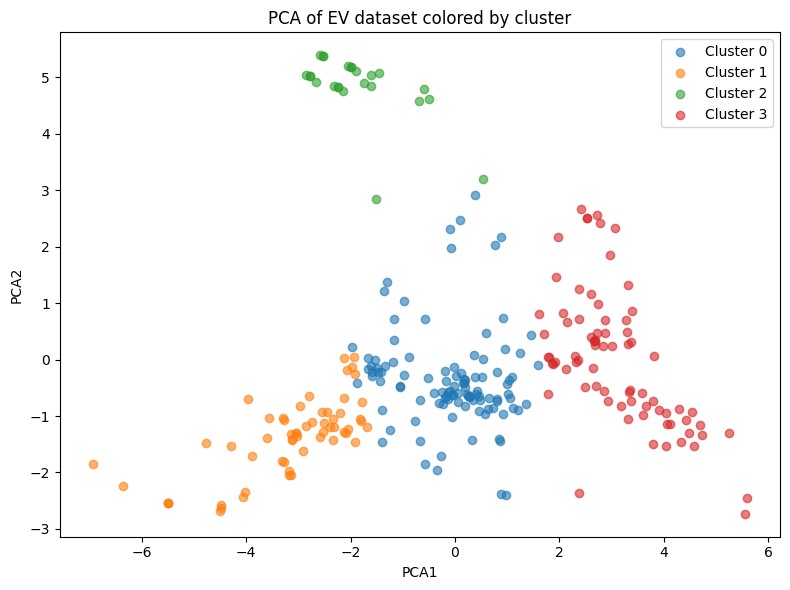

No 'description' column present.
✅ KMeans clustering labels added.
⚠️ Text classification skipped; 'description' or 'writing_style' column missing.


In [ ]:
# Cell 9: Example execution pipeline (adjust filename as needed)
# טוען את קובץ הנתונים (שמור באותה תיקיה כמו ה־Notebook)

try:
    df = pd.read_csv('electric_vehicles_spec_2025.csv.csv')
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print("❌ Dataset file 'electric_vehicles_spec_2025.csv.csv' not found. Make sure it's in the same directory.")
    df = pd.DataFrame()  # מונע קריסה במקרה שאין קובץ

# ניתוח בסיסי
if not df.empty:
    basic_eda(df)
    stats_and_distributions(df)

    #  ניתוח משתנים קטגוריים (טי"ב קירוב)
    try:
        analyze_categorical_features(df)
    except Exception as e:
        print(f"❌ Categorical feature analysis failed: {e}")

    # מציאת חריגים בעמודות נומריות
    try:
        outliers_df = detect_outliers(df, threshold=3)
    except Exception as e:
        print(f"❌ Outlier detection failed: {e}")

    #  Clustering
    try:
        df_clustered, kmeans_model = perform_clustering(df, n_clusters=4)
        if df_clustered is not None:
            segment_analysis(df_clustered)
            df = df_clustered  # עדכון הדאטה לפרויקט
    except Exception as e:
        print(f"❌ Clustering failed: {e}")

    #  עיבוד טקסט ובניית מודלים
    try:
        df_text = text_and_topic_processing(df)
        build_and_evaluate_models(df_text)
    except Exception as e:
        print(f"❌ Text modeling failed: {e}")




In [25]:
# Cell 10: Detecting Outliers (חריגים)

from scipy.stats import zscore

def detect_outliers(df, threshold=3):
    numeric_cols = df.select_dtypes(include=['number'])
    
    if numeric_cols.empty:
        print("⚠️ No numeric columns found for outlier detection.")
        return

    z_scores = numeric_cols.apply(zscore)
    outlier_mask = (abs(z_scores) > threshold)
    outlier_counts = outlier_mask.sum()

    print(" Outliers detected per numeric column (|Z| > {}):".format(threshold))
    print(outlier_counts[outlier_counts > 0])

    total_outliers = outlier_mask.any(axis=1).sum()
    print(f"🔴 Total rows with at least one outlier: {total_outliers} out of {len(df)}")
    
    outliers_df = df[outlier_mask.any(axis=1)]
    display(outliers_df.head())
    return outliers_df

# Example usage:
#outliers_df = detect_outliers(df)


In [27]:
# Cell 11: Exploratory Analysis for Categorical Features
def analyze_categorical_features(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    print("📊 Categorical Columns Analysis:")
    for col in cat_cols:
        print(f"\n📌 Feature: {col}")
        print(" Unique values:", df[col].nunique())
        print(df[col].value_counts(dropna=False).head(10))
        print("-" * 40)
    
    # Optional: visualize top 2–3 categorical features
    for col in cat_cols[:3]:  # just the first 3 for readability
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
